# GMsh Fluid

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/mesh/FVM_Cylinder_GMsh.ipynb)

This example simulates incompressible flow around a cylinder using FVM.

In [ ]:
# %pip install --quiet phiflow meshio
from phi.torch.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.
from tqdm.notebook import trange

Let's download the example mesh file and visualize it!

<Figure size 288x216 with 1 Axes>

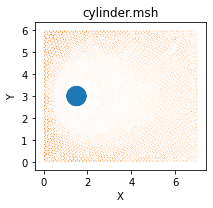

In [ ]:
!wget https://raw.githubusercontent.com/tum-pbs/PhiFlow/master/examples/mesh/cylinder.msh -O cylinder.msh

mesh = geom.load_gmsh('cylinder.msh', ('y-', 'x+', 'y+', 'x-', 'cyl+', 'cyl-'))
plot(Box(x=6, y=6), mesh, overlay='args', size=(4, 3), title='cylinder.msh')

Next we can define the fluid dynamics. The momentum equation uses diffusion and advection while incompressibility is maintained by solving a separate linear system via `make_incompressible`.

In [3]:
@jit_compile_linear
def momentum_eq(u, u_prev, dt, diffusivity=0.01):
    diffusion_term = dt * diffuse.differential(u, diffusivity, correct_skew=False)
    advection_term = dt * advect.differential(u, u_prev, order=1)
    return u + advection_term + diffusion_term

@jit_compile
def implicit_time_step(v, dt):
    v = math.solve_linear(momentum_eq, v, Solve(x0=v), u_prev=v, dt=-dt)
    v, p = fluid.make_incompressible(v, (), Solve('scipy-direct'))
    return v

Now let's set the boundary and initial conditions and run the simulation!

In [11]:
boundary = {'x-': vec(x=1, y=0), 'x+': ZERO_GRADIENT, 'y': 0, 'cyl': 0}
velocity = Field(mesh, tensor(vec(x=0, y=0)), boundary)
v_trj = math.iterate(implicit_time_step, batch(time=100), velocity, dt=0.001, range=trange)

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
plot(v_trj * .1, v_trj.to_grid(), animate='time')